## Применение сверточных нейронных сетей (многоклассовая классификация)

In [ ]:
import pathlib
import os
import itertools

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [50]:
base_path = pathlib.Path('../blobs/sign-language-mnist')

train = pd.read_csv(base_path / 'sign_mnist_train.csv')
test = pd.read_csv(base_path / 'sign_mnist_test.csv')

train['label'] = train['label'].astype(int)
test['label'] = test['label'].astype(int)

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

train[train.columns[1:]] = train[train.columns[1:]] / 255.
test[test.columns[1:]] = test[test.columns[1:]] / 255.

val, test = train_test_split(test, test_size=0.5, shuffle=False)

In [52]:
labels = ['Unknown', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

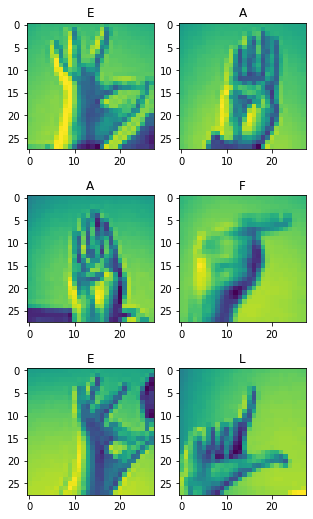

In [108]:
fig = plt.figure(figsize=(5, 9))
for i in range(6):
    ax = fig.add_subplot(3, 2, i + 1)
    ax.imshow(val.iloc[i][1:].values.reshape(28, 28))
    ax.set_title(labels[val.iloc[i, 0]])
plt.show()

In [160]:
def create_dense_layers(n=64):
    return keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(n, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(len(labels))
    ])

def create_model():
    return keras.Sequential([
        keras.layers.Input((28, 28, 1)),
        
        keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.BatchNormalization(),
        
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        
        keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
        keras.layers.BatchNormalization(),
        
        create_dense_layers()
    ])

# TODO: batch normalization?

def compile_model(model):
    model.compile(
        optimizer='rmsprop', 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics=['accuracy']
    )
    
def get_data(df):
    return (
        df.drop('label', axis=1).values.reshape(-1, 28, 28, 1), 
        df['label']
    )

#### Plain model

In [109]:
model = create_model()
compile_model(model)
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 13, 13, 16)        64        
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
batch_normalization_61 (Batc (None, 11, 11, 32)        128       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_62 (Batc (None, 7, 7, 64)        

In [110]:
model.fit(
    *get_data(train), 
    validation_data=get_data(val), 
    epochs=5
)

Train on 27455 samples, validate on 3586 samples
Epoch 1/5
27455/27455 [==============================] - 23s 846us/sample - loss: 1.1814 - acc: 0.9114 - val_loss: 0.5870 - val_acc: 0.9116
Epoch 2/5
27455/27455 [==============================] - 22s 799us/sample - loss: 0.2469 - acc: 0.9865 - val_loss: 0.4927 - val_acc: 0.9108
Epoch 3/5
27455/27455 [==============================] - 21s 774us/sample - loss: 0.1645 - acc: 0.9908 - val_loss: 0.7119 - val_acc: 0.8625
Epoch 4/5
27455/27455 [==============================] - 21s 781us/sample - loss: 0.1367 - acc: 0.9924 - val_loss: 0.4423 - val_acc: 0.9083
Epoch 5/5
27455/27455 [==============================] - 20s 727us/sample - loss: 0.1345 - acc: 0.9915 - val_loss: 0.5413 - val_acc: 0.8656


In [111]:
score, accuracy = model.evaluate(*get_data(test))

3586/3586 [==============================] - 1s 176us/sample - loss: 0.5288 - acc: 0.8728


Okay, **87%** is something, but we overfit a lot

#### Augmentations

In [105]:
gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1
)
x, y = get_data(train)
flow = gen.flow(
    *get_data(train), 
    shuffle=False, 
    batch_size=32
)

aug_model = create_model()
compile_model(aug_model)

aug_model.fit(
    flow,
    validation_data=get_data(val), 
    epochs=5
)

Epoch 1/5
858/858 [==============================] - 24s 28ms/step - loss: 2.6158 - acc: 0.5527 - val_loss: 1.2338 - val_acc: 0.7457
Epoch 2/5
858/858 [==============================] - 22s 25ms/step - loss: 0.9582 - acc: 0.8424 - val_loss: 0.9169 - val_acc: 0.8631
Epoch 3/5
858/858 [==============================] - 20s 23ms/step - loss: 0.7182 - acc: 0.8928 - val_loss: 0.6691 - val_acc: 0.9035
Epoch 4/5
858/858 [==============================] - 19s 22ms/step - loss: 0.6087 - acc: 0.9149 - val_loss: 1.5502 - val_acc: 0.7719
Epoch 5/5
858/858 [==============================] - 19s 22ms/step - loss: 0.5653 - acc: 0.9197 - val_loss: 0.3974 - val_acc: 0.9732


In [106]:
score, accuracy = model.evaluate(*get_data(test))

3586/3586 [==============================] - 1s 166us/sample - loss: 0.3392 - acc: 0.9891


Nice! Almost **99%** with no changes in the architecture and in just 5 epochs!

With these results we don't even need to resort to transfer learning. But let's try. We'll use smth small as the task is simple

#### Transfer learning

Built-in keras models all require RGB input. Also, MobileNet needs images of size at least 32\*32. So upscaling and duplicating channels

In [169]:
mobile_model_raw = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(56, 56, 3)
)
mobile_model_raw.trainable = False

In [170]:
input_layer = keras.layers.Input((28, 28, 3))
x = keras.layers.UpSampling2D()(input_layer)
x = mobile_model_raw(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = create_dense_layers(128)(x)
mobile_model = keras.Model(inputs=input_layer, outputs=x)

compile_model(mobile_model)
mobile_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 28, 28, 3)]       0         
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 56, 56, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
sequential_41 (Sequential)   (None, 25)                167193    
Total params: 2,425,177
Trainable params: 167,193
Non-trainable params: 2,257,984
_________________________________________________________________


In [173]:
x, y = get_data(train)
rgb_x = np.repeat(x, 3, -1)
x_val, y_val = get_data(val)
rgb_x_val = np.repeat(x_val, 3, -1)

mobile_model.fit(
    rgb_x,
    y,
    validation_data=(rgb_x_val, y_val), 
    epochs=5
)

Train on 27455 samples, validate on 3586 samples
Epoch 1/5
27455/27455 [==============================] - 94s 3ms/sample - loss: 2.1252 - acc: 0.6138 - val_loss: 4.1013 - val_acc: 0.1350
Epoch 2/5
27455/27455 [==============================] - 87s 3ms/sample - loss: 2.1301 - acc: 0.6140 - val_loss: 4.4278 - val_acc: 0.1297
Epoch 3/5
27455/27455 [==============================] - 85s 3ms/sample - loss: 2.1559 - acc: 0.6131 - val_loss: 4.6543 - val_acc: 0.1076
Epoch 4/5
27455/27455 [==============================] - 90s 3ms/sample - loss: 2.1366 - acc: 0.6195 - val_loss: 4.5383 - val_acc: 0.1339
Epoch 5/5
27455/27455 [==============================] - 90s 3ms/sample - loss: 2.1524 - acc: 0.6148 - val_loss: 4.4807 - val_acc: 0.1344


In [172]:
x, y = get_data(test)
rgb_x = np.repeat(x, 3, -1)
score, accuracy = mobile_model.evaluate(rgb_x, y)

3586/3586 [==============================] - 8s 2ms/sample - loss: 4.0217 - acc: 0.1645


Something's not right. Though there's initially some progress, the loss just stops at arount 2.11 and never goes down. Even after 10 epochs train accuracy is around 61%. Need to investigate. Anyhow, our performance without transfer learning is beyound expectations.